# Implementation LSTM model for Forecasting

In [29]:
import time
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## DATA INGESTION

In [31]:
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2019, 1, 1)
end_date = date(2024, 3, 31)

data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [32]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-01,3327.215332,3327.215332,3327.215332,3327.215332,2594.003906,0
2019-01-02,3281.761475,3309.033691,3263.580078,3281.761475,2558.566406,82441033
2019-01-03,3254.489258,3309.033691,3254.489258,3290.852295,2565.654297,102805905
2019-01-04,3290.852295,3327.215332,3281.761475,3327.215332,2594.003906,125907734
2019-01-07,3363.578369,3372.668945,3327.215332,3327.215332,2594.003906,82106628


In [33]:
data.reset_index(inplace=True)

input_feat = input("Masukkan feature yang akan digunakan ('Adj Close','Close'): ")
data = data[["Date", input_feat]]
data

,Date,Close
0,2019-01-01,3327.215332
1,2019-01-02,3281.761475
2,2019-01-03,3290.852295
3,2019-01-04,3327.215332
4,2019-01-07,3327.215332
...,...,...
1285,2024-03-22,6125.000000
1286,2024-03-25,6250.000000
1287,2024-03-26,6300.000000
1288,2024-03-27,6250.000000


## DATA PROCESSING

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [35]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [36]:
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [37]:
sequence_length = 1
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [38]:
tf.random.set_seed(7)

## Modeling

In [39]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

# Training


In [40]:
optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
model_final = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, 
                         callbacks=[early_stopping], 
                         validation_data=(X_test, y_test))

Epoch 1/100
33/33 - 6s - loss: 0.1363 - mean_absolute_error: 0.3403 - val_loss: 0.2551 - val_mean_absolute_error: 0.4989 - 6s/epoch - 168ms/step
Epoch 2/100
33/33 - 1s - loss: 0.0197 - mean_absolute_error: 0.1127 - val_loss: 0.0808 - val_mean_absolute_error: 0.2765 - 514ms/epoch - 16ms/step
Epoch 3/100
33/33 - 0s - loss: 0.0116 - mean_absolute_error: 0.0846 - val_loss: 0.0519 - val_mean_absolute_error: 0.2205 - 492ms/epoch - 15ms/step
Epoch 4/100
33/33 - 0s - loss: 0.0096 - mean_absolute_error: 0.0774 - val_loss: 0.0354 - val_mean_absolute_error: 0.1820 - 463ms/epoch - 14ms/step
Epoch 5/100
33/33 - 0s - loss: 0.0074 - mean_absolute_error: 0.0670 - val_loss: 0.0186 - val_mean_absolute_error: 0.1324 - 470ms/epoch - 14ms/step
Epoch 6/100
33/33 - 0s - loss: 0.0050 - mean_absolute_error: 0.0563 - val_loss: 0.0051 - val_mean_absolute_error: 0.0691 - 477ms/epoch - 14ms/step
Epoch 7/100
33/33 - 0s - loss: 0.0036 - mean_absolute_error: 0.0466 - val_loss: 6.2601e-04 - val_mean_absolute_error: 0.

## Evaluation

In [41]:
loss = model.evaluate(X_test, y_test)
round_loss = [round(num, 5) for num in loss]
print("Loss :", round_loss)

predict = model.predict(X_test)

9/9 [==============================] - 0s 7ms/step - loss: 6.2601e-04 - mean_absolute_error: 0.0200
Loss : [0.00063, 0.01998]
9/9 [==============================] - 1s 5ms/step


In [42]:
print("-"*5, " Metric ","-"*5)
print('RMSE : ', round(sqrt(metrics.mean_squared_error(y_test, predict)), 5))
print('MSE  : ', round(abs(metrics.mean_squared_error(y_test, predict)), 5))
print('MAE  : ', round(metrics.mean_absolute_error(y_test, predict), 5))

-----  Metric  -----
RMSE :  0.02502
MSE  :  0.00063
MAE  :  0.01998


## Visualization

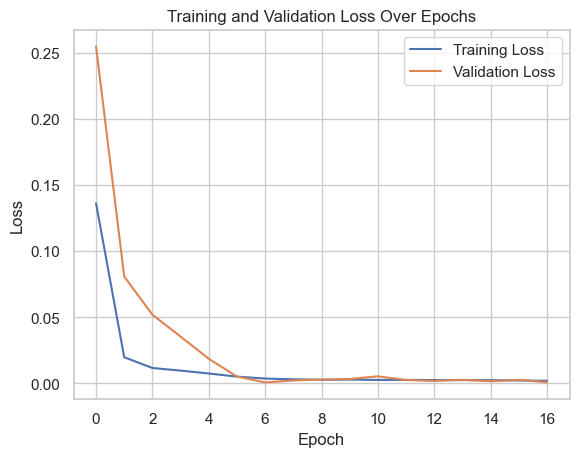

In [43]:
sns.set(style="whitegrid")

sns.lineplot(x=range(len(model_final.history['loss'])), y=model_final.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(model_final.history['val_loss'])), y=model_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Saving Model

In [44]:
import time

ts = int(time.time())
file_path = f"../lstm_stock/{ts}/"
model.save(filepath=file_path, save_format='tf')
print("Success saving model!")

KeyboardInterrupt: 